<a href="https://colab.research.google.com/github/tolom131/machine-learning-project/blob/master/assignment/12/assignment_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os
from torchvision.utils import make_grid

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from numpy.random import normal
from math import sqrt

## load data

In [3]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

real            = torch.from_numpy(data['real_images']).float()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## hyper-parameters

In [4]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 80
size_minibatch  = 50
dim_latent      = 64
dim_channel     = 1
learning_rate_discriminator = 0.0001
learning_rate_generator     = 0.0001

In [5]:
import random
def affine(image, shear=0, scale=1, rate=[10, 10]):

    func_plt = transforms.functional.to_pil_image
    func_affine = transforms.functional.affine
    func_tensor = transforms.functional.to_tensor

    for i in range(len(image)):

        # random movement
        if rate[0] != 0:
            rate_1 = np.random.randint(-rate[0], rate[0]+1)
            rate_2 = np.random.randint(-rate[1], rate[1]+1)
            movement = [rate_1, rate_2]
        else:
            movement = rate

        if isinstance(scale, list):
            rescale = np.random.randint(scale[0], scale[1]+1) / 10
        else:
            rescale = scale


        trans_image = func_plt(image[i])
        trans_image = func_affine(trans_image, angle=0, shear=shear, scale=rescale, translate=movement)
        trans_image = func_tensor(trans_image)
        trans_image = trans_image.numpy()

        if i == 0:
            image_list = trans_image
        else:
            image_list = np.concatenate([image_list, trans_image], axis=0)

    return image_list

In [6]:
real_image = real[::2]
affine_12 = affine(real_image, scale=[5, 12], rate=[0, 0])
affine_random = affine(real_image, scale=1, rate=[3, 3])

## custom data loader for the PyTorch framework

In [7]:
class dataset (Dataset):
    def  __init__(self, data):

        self.data = data

    def __getitem__(self, index):

        data = self.data[index]
        data = torch.FloatTensor(data).unsqueeze(dim=0)

        return data
  
    def __len__(self):
        
        return self.data.shape[0]

## construct datasets and dataloaders for training and testing

In [8]:
# image_train = np.concatenate([real[1::2], affine_12, affine_random], axis=0)
dataset_real    = dataset(real)
dataloader_real = DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

In [9]:
# image_train.shape

## shape of the data when using the data loader

In [10]:
image_real = dataset_real[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_real.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 32, 32])
*******************************************************************


## class for the neural network 

In [11]:
class Generator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=8):
        
		super(Generator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2

		self.network = nn.Sequential(
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(in_channel, dim_feature * 8, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 8),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 8, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 4),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 2),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 2, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 1),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 1, out_channel, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(out_channel),
			# ================================================================================
			nn.Sigmoid(),
			# ================================================================================
		) 			

		self.initialize_weight()
		
		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass

In [12]:
class Discriminator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=128):
        
		super(Discriminator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2
		
		self.feature = nn.Sequential(
            nn.Dropout(0.1),
			# ================================================================================
			nn.Conv2d(in_channel, dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 4, dim_feature * 8, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 8, dim_feature * 16, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
		)	
		
		self.classifier = nn.Sequential(
			# ================================================================================
			nn.Linear(dim_feature * 16, dim_feature * 8, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 8, dim_feature * 4, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 4, dim_feature * 2, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 2, dim_feature * 1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 1, out_channel, bias=True),
			# ================================================================================
		) 

		self.network = nn.Sequential(
			self.feature,
			nn.Flatten(),
			self.classifier,
		)

		self.initialize_weight()

		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass

In [13]:
generator       = Generator(dim_latent, 1, 70).to(device)
discriminator   = Discriminator(dim_channel, 1, 70).to(device)

optimizer_generator     = torch.optim.AdamW(generator.parameters(), lr=learning_rate_generator, betas=(0.9, 0.999))
optimizer_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate_discriminator, betas=(0.9, 0.999))

initialize model parameters : xavier_uniform
initialize model parameters : xavier_uniform


## compute the prediction

In [14]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [15]:
def compute_loss_discriminator(generator, discriminator, latent, data_real):

    data_fake       = compute_prediction(generator, latent)
    prediction_real = compute_prediction(discriminator, data_real)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion   = nn.BCEWithLogitsLoss()
    
    label_real  = torch.ones_like(prediction_real)
    label_fake  = torch.zeros_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_real = criterion(prediction_real, label_real)
    loss_fake = criterion(prediction_fake, label_fake)
    # 
    # ==================================================

    loss_discriminator = (loss_real + loss_fake) / 2.0

    return loss_discriminator

In [16]:
def compute_loss_generator(generator, discriminator, latent):

    data_fake       = compute_prediction(generator, latent)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion       = nn.BCEWithLogitsLoss()

    label_real      = torch.ones_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_generator  = criterion(prediction_fake, label_real)
    # 
    # ==================================================

    return loss_generator

## compute the accuracy

In [17]:
def get_center_index(binary_image):
    
    area_square = np.sum(binary_image)

    height = binary_image.shape[0]
    width = binary_image.shape[1]

    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    indices_X, indices_Y = np.meshgrid(x, y)

    x_mean = np.sum(binary_image * indices_X) / area_square
    y_mean = np.sum(binary_image * indices_Y) / area_square

    return (x_mean, y_mean)

In [18]:
# create ideal square image which has the same area to the input image
def create_label(binary_images):
    
    label = np.zeros_like(binary_images)
    
    for i, binary_image in enumerate(binary_images):
        
        image_height = binary_image.shape[0]
        image_width = binary_image.shape[1]

        square_image = np.zeros((image_height, image_width))
        square_length = np.round(np.sqrt(np.sum(binary_image)))

        if square_length == 0:
            # when there is no square
            return square_image

        (square_center_x, square_center_y) = get_center_index(binary_image)

        if square_center_x < 0 or square_center_x > image_width - 1 or square_center_y < 0 or square_center_y > image_height - 1:
            return square_image

        top = np.ceil(square_center_y - square_length / 2)
        bottom = np.floor(square_center_y + square_length / 2)
        left = np.ceil(square_center_x - square_length / 2)
        right = np.floor(square_center_x + square_length / 2)

        top = int(top) if top >= 0 else 0
        bottom = int(bottom) if bottom <= image_height - 1 else image_height - 1
        left = int(left) if left >= 0 else 0
        right = int(right) if right <= image_width - 1 else image_width - 1

        square_image[top : bottom + 1, left : right + 1] = 1
        
        label[i] = square_image
        
    return label

In [19]:
def compute_accuracy(prediction):

    prediction  = prediction.squeeze(axis=1)
    
    prediction_binary   = (prediction >= 0.5).cpu().numpy().astype(int)
    label               = create_label(prediction_binary).astype(int)
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [20]:
loss_generator_mean     = np.zeros(number_epoch)
loss_generator_std      = np.zeros(number_epoch)
loss_discriminator_mean = np.zeros(number_epoch)
loss_discriminator_std  = np.zeros(number_epoch)

accuracy_mean   = np.zeros(number_epoch)
accuracy_std    = np.zeros(number_epoch)

## train

In [21]:
def train(generator, discriminator, dataloader):

    loss_epoch_generator      = []
    loss_epoch_discriminator  = []
    accuracy_epoch = []
    
    for index_batch, data_real in enumerate(dataloader):

        size_batch  = len(data_real)
        data_real   = data_real.to(device)
        
        latent  = torch.randn(size_batch, dim_latent, device=device)
        latent  = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()

        optimizer_generator.zero_grad()
        loss_generator = compute_loss_generator(generator, discriminator, latent)
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()

        optimizer_discriminator.zero_grad()
        loss_discriminator = compute_loss_discriminator(generator, discriminator, latent, data_real)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        data_fake   = compute_prediction(generator, latent)
        accuracy    = compute_accuracy(data_fake)

        loss_epoch_generator.append(loss_generator.item())
        loss_epoch_discriminator.append(loss_discriminator.item())
        accuracy_epoch.append(accuracy)

    loss_generator_mean_epoch       = np.mean(loss_epoch_generator)
    loss_generator_std_epoch        = np.std(loss_epoch_generator)
    
    loss_discriminator_mean_epoch   = np.mean(loss_epoch_discriminator)
    loss_discriminator_std_epoch    = np.std(loss_epoch_discriminator)

    accuracy_mean_epoch             = np.mean(accuracy_epoch)
    accuracy_std_epoch              = np.std(accuracy_epoch)

    loss_value_generator        = {'mean' : loss_generator_mean_epoch, 'std' : loss_generator_std_epoch}
    loss_value_discriminator    = {'mean' : loss_discriminator_mean_epoch, 'std' : loss_discriminator_std_epoch}
    accuracy_value              = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch} 

    return loss_value_generator, loss_value_discriminator, accuracy_value


## training epoch

In [22]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_value_generator, loss_value_discriminator, accuracy_value) = train(generator, discriminator, dataloader_real)

    loss_generator_mean[i]      = loss_value_generator['mean']
    loss_generator_std[i]       = loss_value_generator['std']

    loss_discriminator_mean[i]  = loss_value_discriminator['mean']
    loss_discriminator_std[i]   = loss_value_discriminator['std']

    accuracy_mean[i]            = accuracy_value['mean']
    accuracy_std[i]             = accuracy_value['std']

    print(f"epoch : {i}")
    print(f"\tloss_value_generator : {loss_value_generator['mean']}, loss_discriminator_mean : {loss_discriminator_mean['mean']}, acc mean : {accuracy_value['mean']}")

  1%|▏         | 1/80 [00:08<11:49,  8.98s/it]

epoch : 0
	loss_value_discriminator : 1.0671767954562985, acc mean : 70.57548533910084


  2%|▎         | 2/80 [00:17<11:37,  8.94s/it]

epoch : 1
	loss_value_discriminator : 3.0006808801445852, acc mean : 70.35976215074037


  4%|▍         | 3/80 [00:26<11:27,  8.93s/it]

epoch : 2
	loss_value_discriminator : 4.165539469829826, acc mean : 77.93663387260285


  5%|▌         | 4/80 [00:35<11:18,  8.92s/it]

epoch : 3
	loss_value_discriminator : 3.104465896307036, acc mean : 71.08448236993445


  6%|▋         | 5/80 [00:44<11:09,  8.92s/it]

epoch : 4
	loss_value_discriminator : 4.665105334548063, acc mean : 74.39575167574056


  8%|▊         | 6/80 [00:53<10:59,  8.92s/it]

epoch : 5
	loss_value_discriminator : 5.57008003079614, acc mean : 79.32036767206469


  9%|▉         | 7/80 [01:02<10:50,  8.92s/it]

epoch : 6
	loss_value_discriminator : 5.834130312121192, acc mean : 82.75824639757683


 10%|█         | 8/80 [01:11<10:42,  8.92s/it]

epoch : 7
	loss_value_discriminator : 5.053300718928492, acc mean : 85.41726366152498


 11%|█▏        | 9/80 [01:20<10:32,  8.91s/it]

epoch : 8
	loss_value_discriminator : 4.857806907828757, acc mean : 80.37142554253073


 12%|█▎        | 10/80 [01:29<10:23,  8.91s/it]

epoch : 9
	loss_value_discriminator : 4.4369067549705505, acc mean : 68.92688274009038


 14%|█▍        | 11/80 [01:38<10:15,  8.92s/it]

epoch : 10
	loss_value_discriminator : 4.509456731205763, acc mean : 86.9561351158304


 15%|█▌        | 12/80 [01:47<10:06,  8.92s/it]

epoch : 11
	loss_value_discriminator : 5.702797257623007, acc mean : 87.70427724166578


 16%|█▋        | 13/80 [01:55<09:57,  8.92s/it]

epoch : 12
	loss_value_discriminator : 6.009497337563094, acc mean : 88.57635851442664


 18%|█▊        | 14/80 [02:04<09:48,  8.92s/it]

epoch : 13
	loss_value_discriminator : 6.562823179156282, acc mean : 83.89289631843764


 19%|█▉        | 15/80 [02:13<09:39,  8.92s/it]

epoch : 14
	loss_value_discriminator : 6.492551132690075, acc mean : 84.46596241195681


 20%|██        | 16/80 [02:22<09:30,  8.92s/it]

epoch : 15
	loss_value_discriminator : 7.075046262075735, acc mean : 88.25398827493731


 21%|██▏       | 17/80 [02:31<09:21,  8.92s/it]

epoch : 16
	loss_value_discriminator : 7.304308464360791, acc mean : 89.90718986877249


 22%|██▎       | 18/80 [02:40<09:12,  8.92s/it]

epoch : 17
	loss_value_discriminator : 6.12647144739018, acc mean : 84.01872375505864


 24%|██▍       | 19/80 [02:49<09:03,  8.92s/it]

epoch : 18
	loss_value_discriminator : 5.723992913268333, acc mean : 86.87584767869672


 25%|██▌       | 20/80 [02:58<08:54,  8.91s/it]

epoch : 19
	loss_value_discriminator : 6.546280966248623, acc mean : 86.05128785882063


 26%|██▋       | 21/80 [03:07<08:45,  8.91s/it]

epoch : 20
	loss_value_discriminator : 7.102464149164599, acc mean : 89.33890365971311


 28%|██▊       | 22/80 [03:16<08:36,  8.91s/it]

epoch : 21
	loss_value_discriminator : 6.346387373188207, acc mean : 90.77327051344429


 29%|██▉       | 23/80 [03:25<08:27,  8.91s/it]

epoch : 22
	loss_value_discriminator : 5.033469164094259, acc mean : 87.7337804164167


 30%|███       | 24/80 [03:34<08:19,  8.92s/it]

epoch : 23
	loss_value_discriminator : 6.21259199186813, acc mean : 90.13875823588299


 31%|███▏      | 25/80 [03:42<08:10,  8.91s/it]

epoch : 24
	loss_value_discriminator : 6.6434770517571025, acc mean : 93.92575366649105


 32%|███▎      | 26/80 [03:51<08:01,  8.91s/it]

epoch : 25
	loss_value_discriminator : 7.242678852968438, acc mean : 95.01694826638604


 34%|███▍      | 27/80 [04:00<07:52,  8.91s/it]

epoch : 26
	loss_value_discriminator : 7.520658681559008, acc mean : 95.57841298551868


 35%|███▌      | 28/80 [04:09<07:43,  8.91s/it]

epoch : 27
	loss_value_discriminator : 7.209997232570204, acc mean : 93.10544765839617


 36%|███▋      | 29/80 [04:18<07:34,  8.91s/it]

epoch : 28
	loss_value_discriminator : 7.111632812854856, acc mean : 93.58173099179011


 38%|███▊      | 30/80 [04:27<07:26,  8.92s/it]

epoch : 29
	loss_value_discriminator : 7.551131669865098, acc mean : 94.64106318870121


 39%|███▉      | 31/80 [04:36<07:17,  8.92s/it]

epoch : 30
	loss_value_discriminator : 7.859866924064104, acc mean : 96.48424340631499


 40%|████      | 32/80 [04:45<07:08,  8.92s/it]

epoch : 31
	loss_value_discriminator : 8.26919542356979, acc mean : 96.37854449755073


 41%|████▏     | 33/80 [04:54<06:59,  8.93s/it]

epoch : 32
	loss_value_discriminator : 8.557052063387493, acc mean : 96.90256967655357


 42%|████▎     | 34/80 [05:03<06:51,  8.94s/it]

epoch : 33
	loss_value_discriminator : 8.767546980880027, acc mean : 96.0405059211574


 44%|████▍     | 35/80 [05:12<06:42,  8.94s/it]

epoch : 34
	loss_value_discriminator : 8.597977022792017, acc mean : 94.71968735784725


 45%|████▌     | 36/80 [05:21<06:33,  8.95s/it]

epoch : 35
	loss_value_discriminator : 7.923069100047266, acc mean : 95.83488309643803


 46%|████▋     | 37/80 [05:30<06:25,  8.96s/it]

epoch : 36
	loss_value_discriminator : 8.602325029151384, acc mean : 97.25896371220153


 48%|████▊     | 38/80 [05:39<06:15,  8.95s/it]

epoch : 37
	loss_value_discriminator : 8.515397204909213, acc mean : 96.47736238469047


 49%|████▉     | 39/80 [05:48<06:07,  8.95s/it]

epoch : 38
	loss_value_discriminator : 8.836178519005, acc mean : 96.49328974373735


 50%|█████     | 40/80 [05:56<05:57,  8.94s/it]

epoch : 39
	loss_value_discriminator : 8.811466072880945, acc mean : 98.10069671918721


 51%|█████▏    | 41/80 [06:05<05:48,  8.94s/it]

epoch : 40
	loss_value_discriminator : 8.974421057590218, acc mean : 94.47197992906038


 52%|█████▎    | 42/80 [06:14<05:39,  8.93s/it]

epoch : 41
	loss_value_discriminator : 5.463020220716983, acc mean : 91.83358672052637


 54%|█████▍    | 43/80 [06:23<05:30,  8.92s/it]

epoch : 42
	loss_value_discriminator : 5.546609398930571, acc mean : 93.20170348539332


 55%|█████▌    | 44/80 [06:32<05:20,  8.91s/it]

epoch : 43
	loss_value_discriminator : 6.172841338224189, acc mean : 90.77444896679346


 56%|█████▋    | 45/80 [06:41<05:11,  8.91s/it]

epoch : 44
	loss_value_discriminator : 7.965862069019051, acc mean : 97.24619983494782


 57%|█████▊    | 46/80 [06:50<05:03,  8.91s/it]

epoch : 45
	loss_value_discriminator : 7.911219120025635, acc mean : 97.43157373279169


 59%|█████▉    | 47/80 [06:59<04:54,  8.91s/it]

epoch : 46
	loss_value_discriminator : 8.870822518370872, acc mean : 97.87466269311325


 60%|██████    | 48/80 [07:08<04:45,  8.92s/it]

epoch : 47
	loss_value_discriminator : 9.232606527417206, acc mean : 97.20094747712265


 61%|██████▏   | 49/80 [07:17<04:36,  8.91s/it]

epoch : 48
	loss_value_discriminator : 10.215271179066148, acc mean : 95.81722764319996


 62%|██████▎   | 50/80 [07:26<04:27,  8.91s/it]

epoch : 49
	loss_value_discriminator : 9.329602330230003, acc mean : 97.48653061250661


 64%|██████▍   | 51/80 [07:35<04:18,  8.92s/it]

epoch : 50
	loss_value_discriminator : 10.315083342929219, acc mean : 98.16850275421521


 65%|██████▌   | 52/80 [07:43<04:09,  8.91s/it]

epoch : 51
	loss_value_discriminator : 10.619857203128726, acc mean : 96.86164085685985


 66%|██████▋   | 53/80 [07:52<04:00,  8.92s/it]

epoch : 52
	loss_value_discriminator : 10.946030383886294, acc mean : 97.66418363943008


 68%|██████▊   | 54/80 [08:01<03:51,  8.92s/it]

epoch : 53
	loss_value_discriminator : 10.33517563620279, acc mean : 97.54956919201776


 69%|██████▉   | 55/80 [08:10<03:43,  8.92s/it]

epoch : 54
	loss_value_discriminator : 10.003744552301805, acc mean : 97.57137103117272


 70%|███████   | 56/80 [08:19<03:34,  8.92s/it]

epoch : 55
	loss_value_discriminator : 10.04081970037416, acc mean : 97.38393320110464


 71%|███████▏  | 57/80 [08:28<03:25,  8.92s/it]

epoch : 56
	loss_value_discriminator : 10.482319964918979, acc mean : 97.00028293836874


 72%|███████▎  | 58/80 [08:37<03:16,  8.92s/it]

epoch : 57
	loss_value_discriminator : 10.414369594219119, acc mean : 96.46651797020176


 74%|███████▍  | 59/80 [08:46<03:07,  8.92s/it]

epoch : 58
	loss_value_discriminator : 11.616438832393913, acc mean : 94.61986806604932


 75%|███████▌  | 60/80 [08:55<02:58,  8.92s/it]

epoch : 59
	loss_value_discriminator : 8.312620409089456, acc mean : 86.34789731318628


 76%|███████▋  | 61/80 [09:04<02:49,  8.92s/it]

epoch : 60
	loss_value_discriminator : 5.734983920704487, acc mean : 89.25268139007026


 78%|███████▊  | 62/80 [09:13<02:40,  8.91s/it]

epoch : 61
	loss_value_discriminator : 7.179053644801295, acc mean : 95.15002283832487


 79%|███████▉  | 63/80 [09:22<02:31,  8.91s/it]

epoch : 62
	loss_value_discriminator : 7.735225615633088, acc mean : 96.91928182084982


 80%|████████  | 64/80 [09:30<02:22,  8.91s/it]

epoch : 63
	loss_value_discriminator : 5.013133542482243, acc mean : 83.20759896021534


 81%|████████▏ | 65/80 [09:39<02:13,  8.91s/it]

epoch : 64
	loss_value_discriminator : 6.654554824496424, acc mean : 87.46578014621102


 82%|████████▎ | 66/80 [09:48<02:04,  8.92s/it]

epoch : 65
	loss_value_discriminator : 5.695726633071899, acc mean : 88.2055814224087


 84%|████████▍ | 67/80 [09:57<01:55,  8.92s/it]

epoch : 66
	loss_value_discriminator : 7.6675799156344215, acc mean : 92.39602884128237


 85%|████████▌ | 68/80 [10:06<01:46,  8.92s/it]

epoch : 67
	loss_value_discriminator : 7.0087597370147705, acc mean : 92.4872585847798


 86%|████████▋ | 69/80 [10:15<01:38,  8.92s/it]

epoch : 68
	loss_value_discriminator : 7.809405551400295, acc mean : 97.04038547104138


 88%|████████▊ | 70/80 [10:24<01:29,  8.92s/it]

epoch : 69
	loss_value_discriminator : 6.746050386927848, acc mean : 93.01070477577898


 89%|████████▉ | 71/80 [10:33<01:20,  8.92s/it]

epoch : 70
	loss_value_discriminator : 6.868875398192295, acc mean : 95.5200425987772


 90%|█████████ | 72/80 [10:42<01:11,  8.91s/it]

epoch : 71
	loss_value_discriminator : 7.244785322699436, acc mean : 95.2324849863741


 91%|█████████▏| 73/80 [10:51<01:02,  8.91s/it]

epoch : 72
	loss_value_discriminator : 7.066825339960498, acc mean : 96.54387818413736


 92%|█████████▎| 74/80 [11:00<00:53,  8.92s/it]

epoch : 73
	loss_value_discriminator : 8.471939702366674, acc mean : 97.5583282737604


 94%|█████████▍| 75/80 [11:09<00:44,  8.91s/it]

epoch : 74
	loss_value_discriminator : 8.878841233807941, acc mean : 97.2235183661508


 95%|█████████▌| 76/80 [11:17<00:35,  8.92s/it]

epoch : 75
	loss_value_discriminator : 8.638672562532646, acc mean : 98.86023392123242


 96%|█████████▋| 77/80 [11:26<00:26,  8.91s/it]

epoch : 76
	loss_value_discriminator : 8.953186456547227, acc mean : 99.03201610115367


 98%|█████████▊| 78/80 [11:35<00:17,  8.92s/it]

epoch : 77
	loss_value_discriminator : 9.216702136882516, acc mean : 98.75580465603161


 99%|█████████▉| 79/80 [11:44<00:08,  8.92s/it]

epoch : 78
	loss_value_discriminator : 10.888656006302945, acc mean : 96.09596553644714


100%|██████████| 80/80 [11:53<00:00,  8.92s/it]

epoch : 79
	loss_value_discriminator : 9.685604145360548, acc mean : 93.03607057333774


---

# functions for visualizing the results 

---

## plot curve

In [23]:
def plot_image_grid(data, nRow, nCol, filename=None):

    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))
    
    data = data.detach().cpu()

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            image   = np.squeeze(data[k], axis=0)

            axes[i, j].imshow(image, cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [24]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [25]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [26]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title, filename=None):

    fig = plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [27]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [28]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [29]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [30]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [31]:
def function_result_01():

    print('[plot examples of the real images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_real)
    step        = int(np.floor(number_data / (nRow * nCol)))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    data = dataset_real[index_data]
    data = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [32]:
def function_result_02():

    print('[plot examples of the fake images]')
    print('') 

    nRow = 8
    nCol = 6
    number_latent = nRow * nCol

    latent  = torch.randn(number_latent, dim_latent, device=device)
    latent  = torch.reshape(latent, [number_latent, dim_latent, 1, 1])

    generator.eval()

    data_fake   = generator(latent)
    filename    = 'fake_image.png'

    plot_image_grid(data_fake, nRow, nCol, filename)

In [33]:
def function_result_03():

    print('[plot the generator loss]')
    print('') 

    plot_curve_error(loss_generator_mean, loss_generator_std, 'epoch', 'loss', 'generator loss', 'loss_generator.png')

In [34]:
def function_result_04():
    
    print('[plot the discriminator loss]')
    print('') 
    
    plot_curve_error(loss_discriminator_mean, loss_discriminator_std, 'epoch', 'loss', 'discriminator loss', 'loss_discriminator.png')

In [35]:
def function_result_05():
    
    print('[plot the accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean, accuracy_std, 'epoch', 'accuracy', 'training accuracy', 'training_accuracy.png')

In [36]:
def function_result_06():
    
    print('[print the generator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_generator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [37]:
def function_result_07():
    
    print('[print the discriminator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_discriminator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [38]:
def function_result_08():
    
    print('[print the accuracy at the last 10 epochs]')
    print('') 

    data_last = get_data_last(accuracy_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [39]:
def function_result_09():
    
    print('[print the best accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean, -10)
    print('best accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the real images]



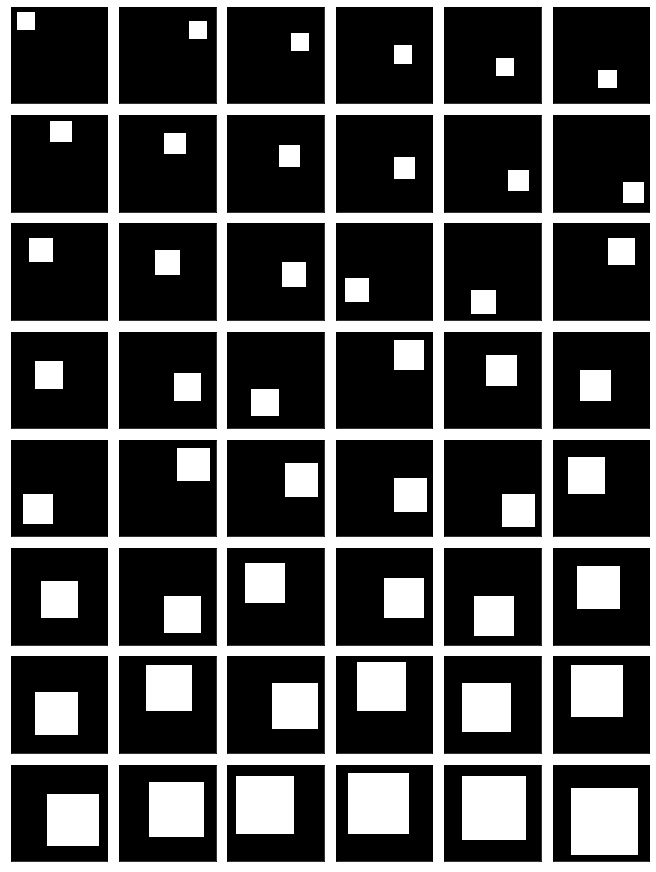


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the fake images]



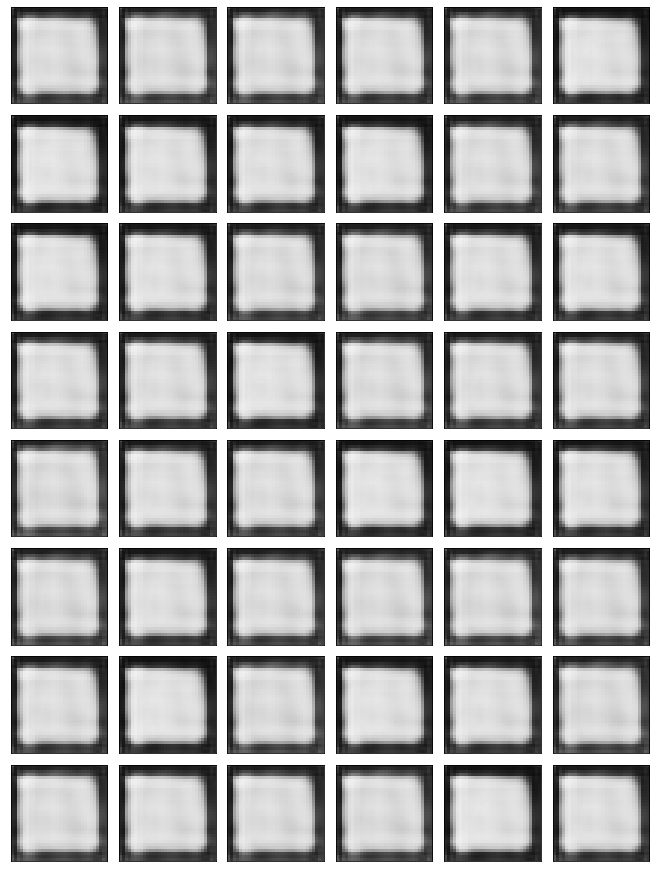


################################################################################
#
# RESULT # 03
#
################################################################################

[plot the generator loss]



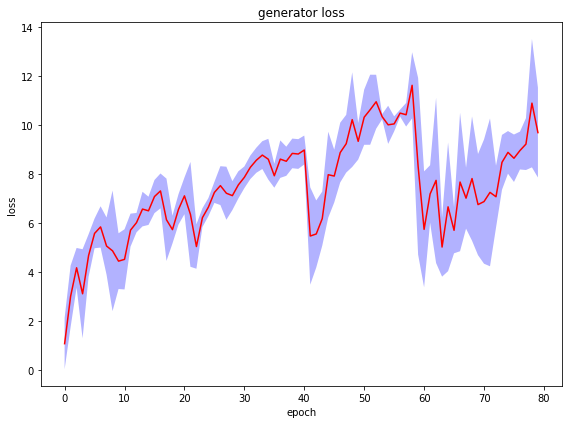


################################################################################
#
# RESULT # 04
#
################################################################################

[plot the discriminator loss]



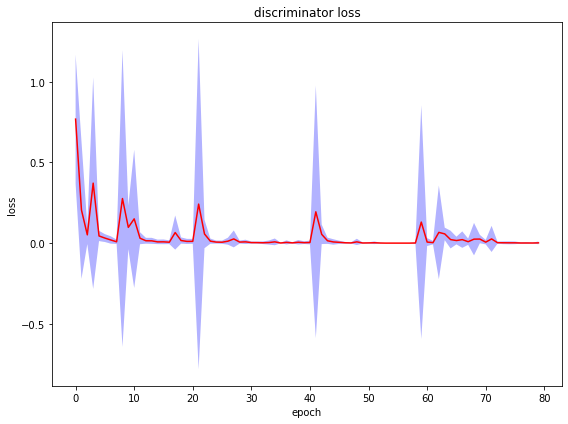


################################################################################
#
# RESULT # 05
#
################################################################################

[plot the accuracy]



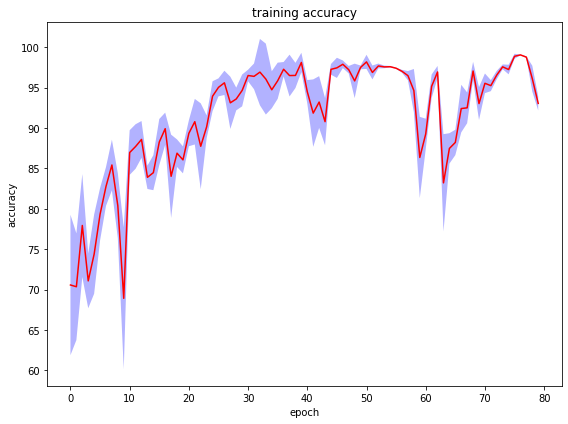


################################################################################
#
# RESULT # 06
#
################################################################################

[print the generator loss at the last 10 epochs]

index =  0, value = 6.8688753982
index =  1, value = 7.2447853227
index =  2, value = 7.0668253400
index =  3, value = 8.4719397024
index =  4, value = 8.8788412338
index =  5, value = 8.6386725625
index =  6, value = 8.9531864565
index =  7, value = 9.2167021369
index =  8, value = 10.8886560063
index =  9, value = 9.6856041454

################################################################################
#
# RESULT # 07
#
################################################################################

[print the discriminator loss at the last 10 epochs]

index =  0, value = 0.0059913048
index =  1, value = 0.0261437252
index =  2, value = 0.0027447217
index =  3, value = 0.0021697113
index =  4, value = 0.0018475817
index =  5, value = 0.0018211276
ind

In [40]:
number_result = 9

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)